# Pull all PSP data

Tamar Ervin
July 28, 2023

In [2]:
import glob
import pyspedas
from pyspedas import time_string, time_double
from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
import sunpy 
import sys, os
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

import tools.utilities as utils
import tools.sigma as sigma
from tools.calculations import calc_beta
import tools.psp_funcs as psp_funcs
import tools.pfss_funcs as pfss_funcs


import sunpy.coordinates as scoords
from scipy.interpolate import interp1d
from plasmapy.formulary import beta, magnetic_pressure, thermal_pressure, ion_sound_speed
from astropy.constants import k_B
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import scipy.constants as con


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import animation, rc
from IPython.display import HTML
from astropy.coordinates import SkyCoord

import astropy.constants as const
import astropy.units as u
from ntpath import basename
import numpy as np
from urllib.request import urlretrieve
import os 

rc('animation',html='html5')


RES_DIR = os.path.realpath('results')
for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

02-Feb-24 16:46:25: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

# Data Download

In [ ]:
time_range = ['2023-03-10/00:00', '2023-03-24/00:00']
enc = 'E15'
edens = 'ENC15_QTN_Electron_Density.csv'

In [ ]:
# # FIELDS
# fields_vars = pyspedas.psp.fields(trange=time_range, time_clip=True, datatype='mag_RTN_4_Sa_per_Cyc')

# # RFS
# rfs_vars = pyspedas.psp.fields(trange=time_range, time_clip=True, level='l3', datatype='rfs_lfr')

# # SPAN-Ion - Proton Moments
# pvars = pyspedas.psp.spi(trange=time_range, datatype='sf00_l3_mom', 
#                             level='l3', time_clip=True)

# # SPAN-Ion - Alpha Particle Moments
# avars = pyspedas.psp.spi(trange=time_range, datatype='sf0a_l3_mom', 
#                             level='l3', time_clip=True)

# # SPAN-Electron - Electron Moments
# spe_vars = pyspedas.psp.spe(trange=time_range, level='l2', time_clip=True)

# PARKER

In [ ]:
# check if folder exists
folder_path = os.path.realpath('results')
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")

### FIELDS

In [ ]:
files = glob.glob(os.path.join(os.path.realpath(os.path.join('psp_data', 'fields/l2/mag_rtn_4_per_cycle/2023')), "*"), recursive=True)
vars = cdf_to_tplot(files[4:8])
dt = get_data('psp_fld_l2_mag_RTN_4_Sa_per_Cyc')
# date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

# rd = {'Time': date_obj, 'Br': dt.y[:, 0], 'Bt': dt.y[:, 1], 'Bn': dt.y[:, 2]}
# dfmag = pd.DataFrame(data=rd)
# dfmag.to_csv(os.path.join(RES_DIR, 'fields.csv'))

In [ ]:
waveoutput = pyspedas.analysis.twavpol.wavpol(dt.times, dt.y[:, 0], dt.y[:, 1], dt.y[:, 2])
waveoutput

In [ ]:
# time_range = ['2023-03-16/08:00', '2023-03-18/00:00']
# fields_vars = pyspedas.psp.fields(trange=time_range, time_clip=True, datatype='mag_RTN')
waveoutput2 = pyspedas.twavpol('psp_fld_l2_mag_RTN_4_Sa_per_Cyc')

In [ ]:
tplot(['psp_fld_l2_mag_RTN_4_Sa_per_Cyc_waveangle'])

In [ ]:
len(waveoutput[0])
plt.imshow(waveoutput[3])
waveoutput[3].shape

### RFS 

In [ ]:
# path = glob.glob(os.path.join(os.path.realpath(os.path.join('psp_data', 'fields/l2/rfs_lfr')), "*"), recursive=True)
# files = glob.glob(os.path.join(path[0], '*'))[:2]
# vars = cdf_to_tplot(files)

dt = get_data('psp_fld_l2_rfs_lfr_auto_averages_ch0_V1V2')
# date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

# rd = {'Time': date_obj, 'Br': dt.y[:, 0], 'Bt': dt.y[:, 1], 'Bn': dt.y[:, 2]}
# df = pd.DataFrame(data=rd)
# df = df.set_index(df.Time)
# df.to_csv(os.path.join(enc, 'results/fields.csv'))

In [ ]:
vars

In [ ]:
tplot(['psp_fld_l2_rfs_lfr_auto_averages_ch0_V1V2'])

### PROTONS

In [ ]:
path = glob.glob(os.path.join(os.path.realpath(os.path.join('psp_data', 'sweap/spi/l3/spi_sf00_l3_mom')), "*"), recursive=True)
files = glob.glob(os.path.join(path[0], '*'))

vars = cdf_to_tplot(files)
dt = get_data('VEL_RTN_SUN')
dt2 = get_data('DENS')
dt3 = get_data('TEMP')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

rd = {'Time': date_obj, 'vr': np.abs(dt.y[:, 0]), 'vt': dt.y[:, 1], 'vn': dt.y[:, 2], 'Np': dt2.y, 'Tp': dt3.y}
df = pd.DataFrame(data=rd)

### ADD ANGLE
vx, vy, vz = [get_data('VEL_SC').y[:, i] for i in np.arange(0, 3)]
mx, my, mz = [get_data('MAGF_INST').y[:, i] for i in np.arange(0, 3)]
vdotb = vx*mx + vy*my + vz*mz
v = np.sqrt(vx**2 + vy**2 + vz**2)
b = np.sqrt(mx**2 + my**2 + mz**2)
angle_vb = np.arccos(vdotb/(v*b))

df['angle_vb'] = angle_vb

# df = df.set_index(df.Time)
df.to_csv(os.path.join(RES_DIR, 'protons.csv'))

In [ ]:
tplot(['VEL_INST',
 'VEL_SC',
 'VEL_RTN_SUN',
 'SC_VEL_RTN_SUN'])
vars


In [ ]:
fig, axs = plt.subplots(1, figsize=[10, 5])

axs.scatter(df.rAU, df.Ahe) 
# axs[1].scatter(df.Np, df.vr)
axs.set(ylabel=r'$\rm A_{He} \; [nT]$', xlabel=r'$\rm r_{AU}$', ylim=(-0.05, 0.25))

In [ ]:
tplot(['DENS', 'VEL_RTN_SUN', 'TEMP', 'EFLUX_VS_THETA', 'EFLUX_VS_PHI'])

### ALPHAS

In [ ]:
path = glob.glob(os.path.join(os.path.realpath(os.path.join('psp_data', 'sweap/spi/l3/spi_sf0a_l3_mom')), "*"), recursive=True)
files = glob.glob(os.path.join(path[0], '*'))

vars = cdf_to_tplot(files)
dt = get_data('VEL_RTN_SUN')
dt2 = get_data('DENS')
dt3 = get_data('TEMP')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

# rd = {'Time': date_obj, 'vra': dt.y[:, 0], 'vta': dt.y[:, 1], 'vna': dt.y[:, 2], 'Na': dt2.y, 'Ta': dt3.y}
# dfalp = pd.DataFrame(data=rd)
# # dfalp = dfalp.set_index(dfalp.Time)
# dfalp.to_csv(os.path.join(RES_DIR, 'alphas.csv'))

In [ ]:
tplot(['DENS', 'VEL_RTN_SUN', 'TEMP', 'EFLUX_VS_THETA', 'EFLUX_VS_PHI'])

### ELECTRONS

In [ ]:
files = glob.glob(os.path.join(os.path.realpath(os.path.join('psp_data', 'sweap/spe/l2/spa_sf132e/2023')), "*"), recursive=True)

# vars = cdf_to_tplot(files)
# dt = get_data('VEL_RTN_SUN')
# dt2 = get_data('DENS')
# dt3 = get_data('TEMP')
# date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

# rd = {'Time': date_obj, 'vr': dt.y[:, 0], 'vt': dt.y[:, 1], 'vn': dt.y[:, 2], 'Na': dt2.y, 'Ta': dt3.y}
# dfalp = pd.DataFrame(data=rd)
# dfalp = dfalp.set_index(dfalp.Time)
# dfalp.to_csv(os.path.join(RES_DIR, 'alphas.csv'))

In [ ]:
tplot('psp_spe_EFLUX')


In [ ]:
dt = pd.read_csv(os.path.realpath(os.path.join('psp_data', edens)))
date_obj = [datetime.datetime.strptime(d, '%Y-%m-%d/%H:%M:%S') for d in dt.Time]

rd = {'Time': date_obj, 'Ne': dt.N_QTN}
dfe = pd.DataFrame(data=rd, index=None)
# dfe = dfe.set_index(dfe.Time)
dfe.to_csv(os.path.join(RES_DIR, 'electrons.csv'))

In [ ]:
dt = pd.read_csv(os.path.realpath(os.path.join('results', 'ENC15_SPAN-E_Core_Temperature.csv')))
date_obj = [datetime.datetime.strptime(d, '%Y-%m-%d/%H:%M:%S') for d in dt.Time]

rd = {'Time': date_obj, 'Te': dt['T'], 'Teperp': dt.Tperp, 'Tepara': dt.Tparallel}
dfet = pd.DataFrame(data=rd, index=None)
# # dfe = dfe.set_index(dfe.Time)
dfet.to_csv(os.path.join(RES_DIR, 'electron_temp.csv'))
dfet

### COMBINE DATASETS

In [1]:
RESULTS = '/Users/tamarervin/e15_results/'

In [4]:
df = pd.read_csv(os.path.join(RESULTS, 'protons.csv'), index_col=None)
dfe = pd.read_csv(os.path.join(RESULTS, 'electrons.csv'), index_col=None)
dfet = pd.read_csv(os.path.join(RESULTS, 'electron_temp.csv'), index_col=None)
dfalp = pd.read_csv(os.path.join(RESULTS, 'alphas.csv'), index_col=None)
dfmag = pd.read_csv(os.path.join(RESULTS, 'fields.csv'), index_col=None)
df, dfe, dfet, dfalp = [dd.drop(['Unnamed: 0'], axis=1) for dd in [df, dfe, dfet, dfalp]]
dfmag = dfmag.drop(['Time.1'], axis=1)
df['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in df.Time]
dfe['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dfe.Time]
dfet['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dfet.Time]
dfalp['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in dfalp.Time]
dfmag['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in dfmag.Time]


In [5]:
ff = pd.merge_asof(df, dfalp, on='Time', direction='backward')
ff = pd.merge_asof(ff, dfe, on='Time', direction='backward')
ff = pd.merge_asof(ff, dfet, on='Time', direction='backward')
ff = pd.merge_asof(ff, dfmag, on='Time', direction='backward')
ff = ff.set_index('Time')
ff = ff[np.logical_and(ff.Tp > 0, ff.Ta > 0)].copy()
ff

,vr,vt,vn,Np,Tp,angle_vb,vra,vta,vna,Na,Ta,Ne,Te,Teperp,Tepara,Br,Bt,Bn
Time,,,,,,,,,,,,,,,,,,
2023-03-11 00:31:00.012372,370.10500,-39.605633,-198.782380,73.690605,39.591785,1.253278,450.40564,-84.27983,-198.766310,0.642824,295.291260,NaN,NaN,NaN,NaN,-37.714676,20.905120,-22.913809
2023-03-11 00:31:03.507612,373.58670,-39.006985,-205.046300,6.091787,35.703980,1.221615,393.82540,-52.79187,-266.350600,0.101936,216.986920,NaN,NaN,NaN,NaN,-37.251100,20.603453,-24.216478
2023-03-11 00:31:07.002852,381.17000,-37.100770,-207.492500,5.979801,48.351856,1.169493,424.51660,-53.21598,-284.090850,0.032441,231.989270,NaN,NaN,NaN,NaN,-37.101580,18.859922,-25.950745
2023-03-11 00:31:10.498153,378.44010,-44.918000,-214.567810,6.332146,37.802670,1.237108,477.43050,-65.32400,-217.566670,0.095690,267.791530,NaN,NaN,NaN,NaN,-37.633488,20.072580,-23.924404
2023-03-11 00:31:13.993393,376.88632,-41.804850,-211.866440,7.005348,37.943176,1.191888,485.25104,-70.81986,-144.822510,0.068916,120.480156,NaN,NaN,NaN,NaN,-36.716045,19.882498,-25.496770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-22 07:33:03.575091,357.93550,-35.437890,-54.430620,112.029310,31.467490,1.711997,452.00916,-66.40422,-26.540146,3.475599,244.797410,1427.86,NaN,NaN,NaN,68.166190,-1.582440,30.242674
2023-03-22 07:33:07.070332,352.47476,-46.484770,-40.888565,126.181885,32.164190,1.476263,429.38916,-69.52385,-16.206434,3.680836,233.787800,1427.86,NaN,NaN,NaN,71.732070,9.400283,18.833883
2023-03-22 07:33:10.565632,349.68185,-67.855774,-19.525791,140.512080,32.640213,1.357880,431.26245,-68.72810,-2.947524,4.578975,209.826170,1427.86,NaN,NaN,NaN,68.852135,20.997366,18.844542


In [6]:
# Calculate time differences between consecutive datetime values
from datetime import timedelta
datetime_list = ff.index.to_list()
time_diff_list = [datetime_list[i + 1] - datetime_list[i] for i in range(len(datetime_list) - 1)]

# Calculate the average time difference
average_time_difference = sum(time_diff_list, timedelta()) / len(time_diff_list)
print(average_time_difference)

# Specify the total time period (e.g., 10 minutes)
total_time_period = timedelta(minutes=20)

# Calculate the number of points
number_of_points = total_time_period / average_time_difference

print(f"Number of Points in {total_time_period}: {int(number_of_points)}")


0 days 00:00:03.815886899
Number of Points in 0:20:00: 314


In [7]:
### ----- CALCULATIONS ----- ###
### Vap
ff['B'] = np.sqrt(ff.Br**2 + ff.Bt**2 + ff.Bn**2)
cost = np.abs(ff.Br/ff.B)
ff['vap'] = (ff.vra - ff.vr)/cost

### Ahe
ff['Ahe'] = ff.Na/ff.Np

### TUBULENCE
ff['use_dens'] = ff.Np
ff['sigmac'],ff['sigmar'], ff['vA'], ff['Zp'],ff['Zm'], ff['deltav'], ff['deltab'] = sigma.calc_sigma(ff, num=314)
ff = ff.drop(['use_dens'], axis=1)
ff['diff'] = np.abs(ff.vap)/ff.vA

### MACH NUMBER
ff['MA'] = ff.vr / ff.vA
sound_speed = ion_sound_speed(
    T_e=np.array(ff.Te)*u.eV/k_B,
    T_i=np.array(ff.Tp)*u.eV/k_B,
    # n_e=np.array(ff.Ne)/(u.cm**3),
    # k=k_2,
    ion='p',
    gamma_e=1.29,
    gamma_i=1.59,
).to(u.km/u.s).value
ff['MS'] = ff.vr / sound_speed
ff['MMS'] = ff.vr / np.sqrt(sound_speed**2 + ff.vA**2)

### BETA
ff['beta'] = beta(np.array(ff.Tp)*u.eV, np.array(ff.Np)/(u.cm*u.cm*u.cm), np.array(ff.B)*u.nT).value
ff['betae'] = beta(np.array(ff.Te)*u.eV, np.array(ff.Ne)/(u.cm*u.cm*u.cm), np.array(ff.B)*u.nT).value

# ### MAGNETIC PRESSURE
ff['Pm'] = magnetic_pressure(np.array(ff.B)*u.nT).value

### PROTON PRESSURE
ff['Pp'] = thermal_pressure(np.array(ff.Tp)*u.eV, np.array(ff.Np)/u.cm**3).value

### ALPHA PRESSURE
ff['Pa'] = thermal_pressure(np.array(ff.Ta)*u.eV, np.array(ff.Na)/u.cm**3).value

### ELECTRON PRESSURE
ff['Pe'] = thermal_pressure(np.array(ff.Te)*u.eV, np.array(ff.Ne)/u.cm**3).value

### PARKER DF
parker = ff.copy()
parker

,vr,vt,vn,Np,Tp,angle_vb,vra,vta,vna,Na,...,diff,MA,MS,MMS,beta,betae,Pm,Pp,Pa,Pe
Time,,,,,,,,,,,,,,,,,,,,,
2023-03-11 00:31:00.012372,370.10500,-39.605633,-198.782380,73.690605,39.591785,1.253278,450.40564,-84.27983,-198.766310,0.642824,...,0.835080,2.972685,NaN,NaN,0.492693,NaN,9.487479e-10,4.674419e-10,3.041258e-11,NaN
2023-03-11 00:31:03.507612,373.58670,-39.006985,-205.046300,6.091787,35.703980,1.221615,393.82540,-52.79187,-266.350600,0.101936,...,0.061267,0.860200,NaN,NaN,0.036514,NaN,9.543665e-10,3.484751e-11,3.543815e-12,NaN
2023-03-11 00:31:07.002852,381.17000,-37.100770,-207.492500,5.979801,48.351856,1.169493,424.51660,-53.21598,-284.090850,0.032441,...,0.130533,0.868276,NaN,NaN,0.048397,NaN,9.571837e-10,4.632445e-11,1.205800e-12,NaN
2023-03-11 00:31:10.498153,378.44010,-44.918000,-214.567810,6.332146,37.802670,1.237108,477.43050,-65.32400,-217.566670,0.095690,...,0.302418,0.889702,NaN,NaN,0.040303,NaN,9.515735e-10,3.835162e-11,4.105572e-12,NaN
2023-03-11 00:31:13.993393,376.88632,-41.804850,-211.866440,7.005348,37.943176,1.191888,485.25104,-70.81986,-144.822510,0.068916,...,0.356911,0.931590,NaN,NaN,0.044718,NaN,9.523302e-10,4.258668e-11,1.330282e-12,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-22 07:33:03.575091,357.93550,-35.437890,-54.430620,112.029310,31.467490,1.711997,452.00916,-66.40422,-26.540146,3.475599,...,0.667388,2.320598,NaN,NaN,0.255139,NaN,2.213747e-09,5.648123e-10,1.363160e-10,NaN
2023-03-22 07:33:07.070332,352.47476,-46.484770,-40.888565,126.181885,32.164190,1.476263,429.38916,-69.52385,-16.206434,3.680836,...,0.550308,2.419855,NaN,NaN,0.292428,NaN,2.223621e-09,6.502495e-10,1.378728e-10,NaN
2023-03-22 07:33:10.565632,349.68185,-67.855774,-19.525791,140.512080,32.640213,1.357880,431.26245,-68.72810,-2.947524,4.578975,...,0.641711,2.545193,NaN,NaN,0.333558,NaN,2.202952e-09,7.348134e-10,1.539353e-10,NaN


In [14]:
### FLAG DATA

# check if there is any alpha data
all_nan = parker['Ahe'].isna().all()
parker['flag'] = np.ones(len(parker.Ahe))
if all_nan:
    parker['flag'] = np.zeros(len(parker.Ahe))
else:
    # Flag instances as '0' if all three conditions apply
    flag_condition_1 = (np.abs(parker.Np - parker.Ne) / parker.Ne) <= 0.5
    flag_condition_2 = (parker.Ahe) <= 0.2
    flag_condition_3 = (np.abs(parker.vap) / parker.vA) <= 2
    flag_condition_4 = parker.Te < 200 

    flag_0 = np.logical_and.reduce([flag_condition_1, flag_condition_2, flag_condition_3, flag_condition_4])

parker['flag'][flag_0] = 0


In [15]:
### Create SkyCoord for PSP in the inertial (J2000) frame
tt = pd.to_datetime(ff.index.to_list())

psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', tt
)

### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# projection
ts_common = np.array([dt.timestamp() for dt in tt])
psp_vr_ts = [int(dt.timestamp()) for dt in tt]
psp_vr_common = interp1d(psp_vr_ts,ff.vr,bounds_error=False)(ts_common)*u.km/u.s
psp_at_source_surface = psp_funcs.ballistically_project(psp_carrington,vr_arr=psp_vr_common, r_inner=2.5*u.R_sun)


In [ ]:
### ADD POSITION INFORMAITON AND SAVE
parker['lon'] = psp_carrington.lon.value
parker['lat'] = psp_carrington.lat.value
parker['rAU'] = psp_carrington.radius.to(u.AU).value
parker['sslon'] = psp_at_source_surface.lon.value
parker['sslat'] = psp_at_source_surface.lat.value
parker['ssrAU'] = psp_at_source_surface.radius.to(u.AU).value
parker['NpR2'] = parker.Np * (parker.rAU ** 2)
parker['NeR2'] = parker.Ne * (parker.rAU ** 2)
parker['BrR2'] = parker.Br * (parker.rAU ** 2)
parker.to_csv(os.path.join(RESULTS, 'parker20_gamma.csv'))

# ORBITER

In [ ]:
files = glob.glob(os.path.join(os.path.realpath(os.path.join('solar_orbiter_data', 'mag/L2/2023')), "*"), recursive=True)

vars = cdf_to_tplot(files)
dt = get_data('B_RTN')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

rd = {'Time': date_obj, 'Br': dt.y[:, 0], 'Bt': dt.y[:, 1], 'Bn': dt.y[:, 2]}
mag = pd.DataFrame(data=rd)
# mag = df.set_index(df.Time)
mag.to_csv(os.path.join(RES_DIR, 'mag.csv'))

In [ ]:
files = glob.glob(os.path.join(os.path.realpath(os.path.join('solar_orbiter_data', 'swa/L2/2023')), "*"), recursive=True)

vars = cdf_to_tplot(files)
dt = get_data('V_RTN')
dt2 = get_data('N')
dt3 = get_data('T')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

rd = {'Time': date_obj, 'vr': dt.y[:, 0], 'vt': dt.y[:, 1], 'vn': dt.y[:, 2], 'Np': dt2.y, 'Tp': dt3.y}
swa = pd.DataFrame(data=rd)
# swa = df.set_index(df.Time)
swa.to_csv(os.path.join(RES_DIR, 'swa.csv'))

In [ ]:
tplot(['N', 'V_RTN', 'B_RTN', 'T'])


In [ ]:
ff = pd.merge_asof(swa, mag, on='Time', direction='backward')
ff = ff.set_index('Time')
ff

In [ ]:
orbiter = pd.read_csv('results/orbiter.csv')
orbiter['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in orbiter.Time]
orbiter

In [ ]:
### Create SkyCoord for PSP in the inertial (J2000) frame
ff = swa
tt = pd.to_datetime(ff.index.to_list())
kernels =  astrospice.registry.get_kernels('solar orbiter','predict') 
solo_inertial = astrospice.generate_coords(
    'SOLAR ORBITER', tt

)

### Transform to solar co-rotating frame 
solo_carrington = solo_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# projection
ts_common = np.array([dt.timestamp() for dt in tt])
solo_vr_ts = [int(dt.timestamp()) for dt in tt]
solo_vr_common = interp1d(solo_vr_ts,ff.vr,bounds_error=False)(ts_common)*u.km/u.s
solo_at_source_surface = psp_funcs.ballistically_project(solo_carrington,vr_arr=solo_vr_common, r_inner=2.5*u.R_sun)


In [ ]:
### ----- CALCULATIONS ----- ###
ff = orbiter
### Vap
ff['B'] = np.sqrt(ff.Br**2 + ff.Bt**2 + ff.Bn**2)

### TUBULENCE
ff['use_dens'] = ff.Np
ff['sigmac'],ff['sigmar'], ff['vA'], ff['Zp'],ff['Zm'], ff['deltav'], ff['deltab']  = sigma.calc_sigma(ff, num=8)
ff = ff.drop(['use_dens'], axis=1)

### MACH NUMBER
ff['MA'] = ff.vr / ff.vA
ff['MS'] = np.sqrt((ff.vr)**2 + (ff.vt)**2 + (ff.vn)**2)/con.speed_of_sound

### BETA
ff['beta'] = beta(np.array(ff.Tp)*u.eV, np.array(ff.Np)/(u.cm*u.cm*u.cm), np.array(ff.B)*u.nT).value

# ### MAGNETIC PRESSURE
ff['Pm'] = magnetic_pressure(np.array(ff.B)*u.nT).value

### PROTON PRESSURE
ff['Pp'] = thermal_pressure(np.array(ff.Tp)*u.eV, np.array(ff.Np)/u.cm**3).value

### ORBITER DF
orbiter = ff.copy()

In [ ]:
### ADD POSITION INFORMATION AND SAVE
orbiter['lon'] = solo_carrington.lon.value
orbiter['lat'] = solo_carrington.lat.value
orbiter['rAU'] = solo_carrington.radius.to(u.AU).value
orbiter['sslon'] = solo_at_source_surface.lon.value
orbiter['sslat'] = solo_at_source_surface.lat.value
orbiter['ssrAU'] = solo_at_source_surface.radius.to(u.AU).value
orbiter['NpR2'] = orbiter.Np * (orbiter.rAU ** 2)
orbiter['BrR2'] = orbiter.Br * (orbiter.rAU ** 2)
orbiter.to_csv(os.path.join(RES_DIR, 'orbiter.csv'))
orbiter

In [ ]:
fig, [ax1, ax2] = plt.subplots(2)
ax1.scatter(solo_at_source_surface.lon, ff.vr, s=3)
ax2.scatter(solo_at_source_surface.lon, orbiter.BrR2, s=3)

# ACE DATA

In [ ]:
swe_vars = pyspedas.ace.swe(trange=time_range)
swi_vars = pyspedas.ace.swics(trange=time_range)
mfi_vars = pyspedas.ace.mfi(trange=time_range)


In [ ]:
mfi_vars

In [ ]:
tplot(['BRTN', 'V_RTN', 'Np', 'alpha_ratio', 'C6to5', 'O7to6', 'FetoO'])

In [ ]:
# ['BRTN', 'V_RTN', 'Np', 'alpha_ratio', 'C6to5', 'O7to6', 'FetoO']
# dt = get_data('V_RTN')
# dt2 = get_data('Np')
# dt3 = get_data('alpha_ratio')
B = get_data('BRTN')
# C = get_data('C6to5')
# O = get_data('O7to6')
# Fe = get_data('FetoO')

# date_obj = [datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]
# rd = {'Time': date_obj, 'vr': dt.y[:, 0], 'vt': dt.y[:, 1], 'vn': dt.y[:, 2]} #, 'Np': dt2.y, 'Na': dt3.y*dt2.y, 'Ahe': dt3.y}

date_obj = [datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in B.times]
Brd = {'Time': date_obj, 'Br': B.y[:, 0], 'Bt': B.y[:, 1], 'Bn': B.y[:, 2]}

# date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in C.times]
# Crd = {'Time': date_obj, 'C6to5': C.y, 'O7to6': O.y, 'FetoO': Fe.y}

# dfp, dfb = [pd.DataFrame(data=rd, index=None), pd.DataFrame(data=Brd, index=None)] #, pd.DataFrame(data=Crd)]
# for df in [dfp, dfb]:
#       df = df.set_index(df.Time)

ace = pd.DataFrame(data=Brd, index=None)

# ace = pd.merge_asof(dfp, dfb, on='Time', direction='backward')

In [ ]:
# Generate Time Series to Plot Orbits Over
SPICE_Origin='SUN'
SPICE_Frame='ECLIPJ2000'
reference = SPICE_Origin
frame = SPICE_Frame
unit_dict = {'m' : u.m, 'R_earth' : u.R_earth, 'R_sun' : u.R_sun, 'au' : u.au}    
units='au'
body = spice.Trajectory('Earth')
body.generate_positions(ace.Time, reference, frame)
body.change_units(unit_dict.get(units))
    

In [ ]:
l1_factor = 0.99029
ace_inertial = SkyCoord(body.x, body.y, body.z, representation_type='cartesian')
ace_carrington = ace_inertial.transform_to(sunpy.coordinates.HeliographicCarrington(observer="self", obstime=ace.Time))
ace_carrington = SkyCoord(lon=ace_carrington.lon, lat=ace_carrington.lat, radius=ace_carrington.radius*l1_factor, representation_type="spherical",
                          frame = ace_carrington.frame)


ts_common = np.array([dt.timestamp() for dt in ace.Time])
ace_vr_ts = [int(dt.timestamp()) for dt in ace.Time]
ace_vr_common = interp1d(ace_vr_ts, ace.vr, bounds_error=False)(ts_common)*u.km/u.s
ace_projected = psp_funcs.ballistically_project(ace_carrington, vr_arr=ace_vr_common, r_inner=2.5*u.R_sun)

In [ ]:
ace['lon'] = ace_carrington.lon.value
ace['lat'] = ace_carrington.lat.value
ace['rAU'] = ace_carrington.radius.value
ace['sslon'] = ace_projected.lon.value
ace['sslat'] = ace_projected.lat.value
ace['ssrAU'] = ace_projected.radius.value
ace.to_csv('results/ace.csv')

# WIND

### Data Download

In [6]:
time_range = ['2023-03-16/00:00', '2023-04-01/00:00']

mfi_vars = pyspedas.wind.mfi(trange=time_range)
# swe_vars = pyspedas.wind.swe(trange=time_range) -- no data
threedp_vars = pyspedas.wind.threedp(trange=time_range, datatype='3dp_k0')



03-Feb-24 16:18:36: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/
03-Feb-24 16:18:37: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/wi_h0_mfi_20230316_v04.cdf to wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230316_v04.cdf
03-Feb-24 16:18:39: Download complete: wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230316_v04.cdf
03-Feb-24 16:18:40: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/wi_h0_mfi_20230317_v04.cdf to wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230317_v04.cdf
03-Feb-24 16:18:45: Download complete: wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230317_v04.cdf
03-Feb-24 16:18:45: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/wi_h0_mfi_20230318_v04.cdf to wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230318_v04.cdf
03-Feb-24 16:18:49: Download complete: wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230318_v04.cdf
03-Feb-24 16:18:49: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/wi_h0_mfi_20230

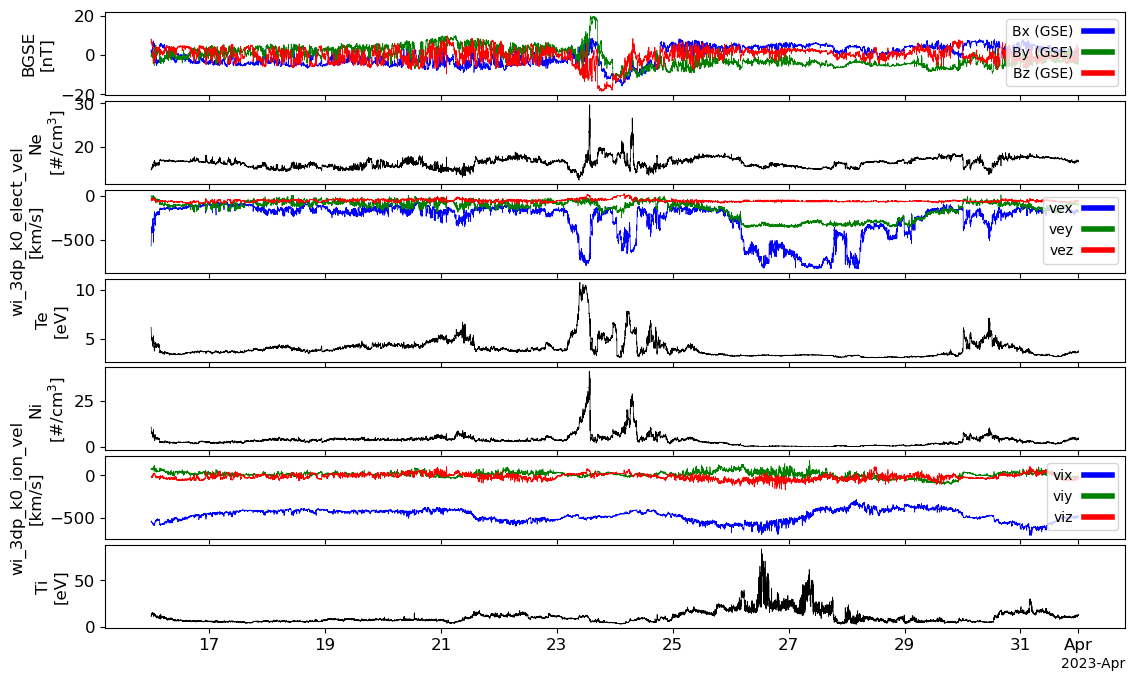

In [8]:

threedp_vars

tplot(['BGSE',
       'wi_3dp_k0_elect_density',
 'wi_3dp_k0_elect_vel',
 'wi_3dp_k0_elect_temp',
 'wi_3dp_k0_ion_density',
 'wi_3dp_k0_ion_vel',
 'wi_3dp_k0_ion_temp'])



In [ ]:
mag = get_data('BGSE')
vel = get_data('wi_3dp_k0_ion_vel')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in mag.times]
date_obj_vr = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in vel.times]

In [ ]:
['BGSE',
'wi_3dp_k0_elect_density',
 'wi_3dp_k0_elect_vel',
 'wi_3dp_k0_elect_temp',
 'wi_3dp_k0_ion_density',
 'wi_3dp_k0_ion_vel',
 'wi_3dp_k0_ion_temp']

B = get_data('BGSE')
dt = get_data('wi_3dp_k0_ion_vel')
dt2 = get_data('wi_3dp_k0_ion_density')
dt3 = get_data('wi_3dp_k0_ion_temp')
dt4 = get_data('wi_3dp_k0_elect_vel')
dt5 = get_data('wi_3dp_k0_elect_density')
dt6 = get_data('wi_3dp_k0_elect_temp')

date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]
rd = {'Time': date_obj, 'vr': np.abs(dt.y[:, 0]), 'vt': dt.y[:, 1], 'vn': dt.y[:, 2], 'Np': dt2.y, 'Tp': dt3.y,
      'vre': dt4.y[:, 0], 'vte': dt4.y[:, 1], 'vne': dt4.y[:, 2], 'Ne': dt5.y, 'Te': dt6.y,}

date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in B.times]
Brd = {'Time': date_obj, 'Br': B.y[:, 0], 'Bt': B.y[:, 1], 'Bn': B.y[:, 2]}

dfp, dfb = [pd.DataFrame(data=rd, index=None), pd.DataFrame(data=Brd, index=None)] 
for df in [dfp, dfb]:
      df = df.set_index(df.Time)

wind = pd.merge_asof(dfp, dfb, on='Time', direction='backward')

In [ ]:
wind = pd.read_csv('results/wind.csv')
wind['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in wind.Time]

### Ballistic Propagation

In [ ]:
def get_sc_trajectory(datetime_arr,spice_str='SPP',
                      origin='Sun',frame='IAU_SUN',
                      representation_type="cartesian",
                      incl_datetimes = False
                      ) :
    if spice_str == 'L1' :
        spice_str = 'Earth'
        modifier= 1.0- ((const.M_earth.value/
                        (const.M_earth.value
                         +const.M_sun.value))/3)**(1/3)
    else : modifier= 1.0
    try : sc = spice.Trajectory(spice_str)
    except :
        valid_strings = [
        'SPP','Earth','L1','SOLO', 'Venus', 'BEPICOLOMBO MPO',
        ]
        return f"Invalid spice string, choose from {valid_strings}"
    sc.generate_positions(datetime_arr, origin, frame)
    sc.change_units(u.au)
    if len(datetime_arr) == 1 or not incl_datetimes:
        sc_coord = SkyCoord(x=sc.x*modifier,
                                  y=sc.y*modifier,
                                  z=sc.z*modifier,
                                  frame= sunpy.coordinates.HeliographicCarrington,
                                  representation_type='cartesian',
                                  observer="Earth",
                                  obstime = datetime_arr[0],
                                  )
    else :
        sc_coord = SkyCoord(x=sc.x*modifier,
                                  y=sc.y*modifier,
                                  z=sc.z*modifier,
                                  frame= sunpy.coordinates.HeliographicCarrington,
                                  representation_type='cartesian',
                                  observer="Earth",
                                  obstime = list(datetime_arr),
                                  )
    sc_coord.representation_type=representation_type
    return sc_coord

In [ ]:
wind.vr

In [ ]:
l1_factor = 0.99029
wind_carrington = get_sc_trajectory(wind.Time,spice_str='L1')
wind_carrington.representation_type = 'spherical'
wind_carrington = SkyCoord(lon=wind_carrington.lon, lat=wind_carrington.lat, radius=wind_carrington.radius*l1_factor, representation_type="spherical",
                          frame = wind_carrington.frame)

ts_common = np.array([dt.timestamp() for dt in wind.Time])
wind_vr_ts = [int(dt.timestamp()) for dt in wind.Time]
wind_vr_common = interp1d(wind_vr_ts, wind.vr, bounds_error=False)(ts_common)*u.km/u.s
wind_projected = psp_funcs.ballistically_project(wind_carrington, vr_arr=wind_vr_common, r_inner=2.5*u.R_sun)

In [ ]:
fig, ax = plt.subplots(2, figsize=[12, 3])
ax[0].scatter(wind.Time, wind_projected.lon.value)
ax[1].scatter(wind_projected.lon.value, wind_projected.lat.value)

### Dataframe Creation

In [ ]:
wind = pd.read_csv('results/wind.csv')
wind['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in wind.Time]
wind

In [ ]:
### ----- CALCULATIONS ----- ###
ff = wind
### Vap
ff['B'] = np.sqrt(ff.Br**2 + ff.Bt**2 + ff.Bn**2)
cost = np.abs(ff.Br/ff.B)
# ff['vap'] = (ff.vra - ff.vr)/cost

# ### Ahe
# ff['Ahe'] = ff.Na/ff.Np

### TUBULENCE
ff['use_dens'] = ff.Np
ff['sigmac'],ff['sigmar'], ff['vA'], ff['Zp'],ff['Zm'], ff['deltav'], ff['deltab'] = sigma.calc_sigma(ff, num=10)
ff = ff.drop(['use_dens'], axis=1)

### MACH NUMBER
ff['MA'] = ff.vr / ff.vA
# ff['MS'] = np.sqrt((ff.vr)**2 + (ff.vt)**2 + (ff.vn)**2)/con.speed_of_sound

### BETA
ff['betap'] = beta(np.array(ff.Tp)*u.eV, np.array(ff.Np)/(u.cm*u.cm*u.cm), np.array(ff.B)*u.nT).value
ff['betae'] = beta(np.array(ff.Te)*u.eV, np.array(ff.Ne)/(u.cm*u.cm*u.cm), np.array(ff.B)*u.nT).value
ff['beta'] = beta(np.array(ff.Tp)*u.eV, np.array(ff.Np)/(u.cm*u.cm*u.cm), np.array(ff.B)*u.nT).value

### MAGNETIC PRESSURE
B = (ff.B*(10**(-9)))
ff['Pm'] = (B**2)/(2*con.mu_0)

### PROTON PRESSURE
Tt = ff.Tp/11605 ## eV to Kelvin
nn = ff.Np/(1e-6) ##cm^-3 to m^-3
ff['Pp'] = nn * con.Boltzmann * Tt

### ALPHA PRESSURE
# Tt = ff.Ta/11605 ## eV to Kelvin
# nn = ff.Na/(1e-6) ##cm^-3 to m^-3
# ff['Pa'] = nn * con.Boltzmann * Tt

### PARKER DF
wind = ff.copy()
wind

In [ ]:
wind['lon'] = wind_carrington.lon.value
wind['lat'] = wind_carrington.lat.value
wind['rAU'] = wind_carrington.radius.value
wind['sslon'] = wind_projected.lon.value
wind['sslat'] = wind_projected.lat.value
wind['ssrAU'] = wind_projected.radius.value
wind['BrR2'] = wind.Br * (wind.rAU**2)
wind['NpR2'] = wind.Np * (wind.rAU**2)
wind['NeR2'] = wind.Ne * (wind.rAU**2)
wind.to_csv('results/wind.csv')

In [ ]:
fig, axs = plt.subplots(6, figsize=[30, 12])
var = ['vr', 'MA', 'Br', 'betap', 'Np', 'sigmac']

for i, vv in enumerate(var):
    axs[i].scatter(wind.sslon, wind[vv], color='thistle', s=3)
    axs[i].set(ylabel=vv)
    axs[i].axvspan(8, 19, color='lightblue', zorder=-1)
# ax.set(xlim=(0, 30))


## Wind + 27 days

In [4]:
import pyspedas
from pyspedas import time_string, time_double
from pytplot import tplot, get_data, cdf_to_tplot, store_data
time_range = ['2023-04-20/00:00', '2023-05-01/00:00']
mfi_vars = pyspedas.wind.mfi(trange=time_range)
# threedp_vars = pyspedas.wind.threedp(trange=time_range, datatype='3dp_k0')

# threedp_vars

02-Feb-24 16:48:46: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/
02-Feb-24 16:48:47: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/wi_h0_mfi_20230420_v04.cdf to wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230420_v04.cdf
02-Feb-24 16:48:52: Download complete: wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230420_v04.cdf
02-Feb-24 16:48:52: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/wi_h0_mfi_20230421_v04.cdf to wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230421_v04.cdf
02-Feb-24 16:48:57: Download complete: wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230421_v04.cdf
02-Feb-24 16:48:58: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/wi_h0_mfi_20230422_v04.cdf to wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230422_v04.cdf
02-Feb-24 16:49:01: Download complete: wind_data/mfi/mfi_h0/2023/wi_h0_mfi_20230422_v04.cdf
02-Feb-24 16:49:01: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/wi_h0_mfi_20230

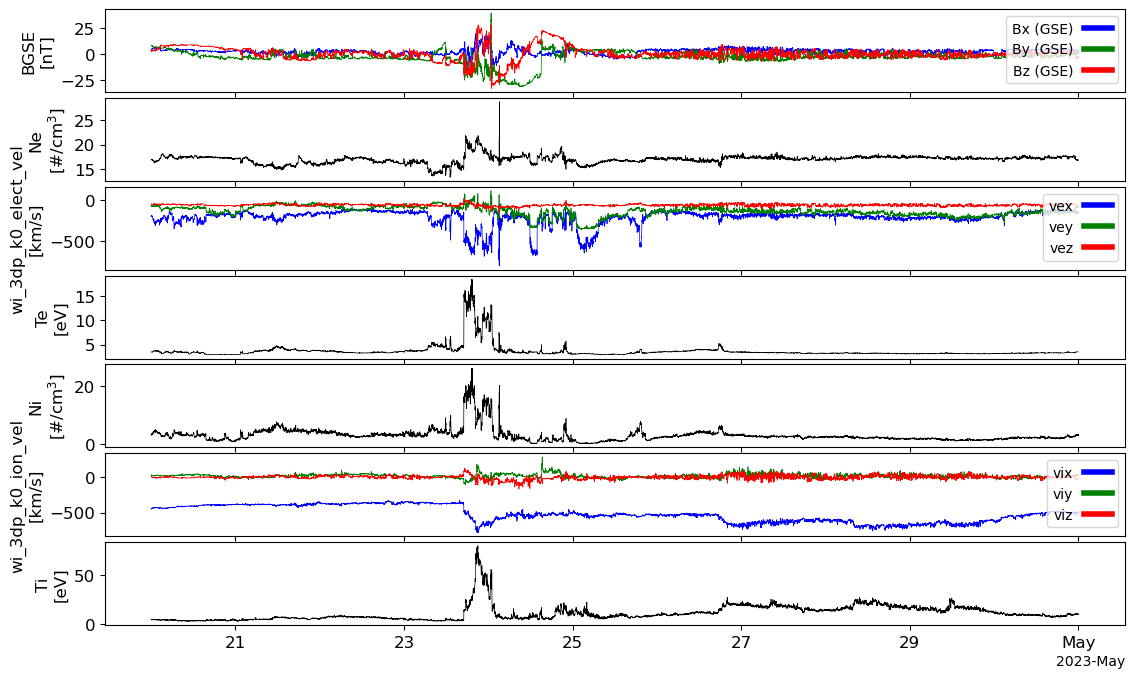

In [5]:

tplot(['BGSE',
       'wi_3dp_k0_elect_density',
 'wi_3dp_k0_elect_vel',
 'wi_3dp_k0_elect_temp',
 'wi_3dp_k0_ion_density',
 'wi_3dp_k0_ion_vel',
 'wi_3dp_k0_ion_temp'])

# COMPARE TRAJECTORIES

In [ ]:
wind_carrington = get_sc_trajectory(wind.Time,spice_str='L1')

plt.plot(wind_carrington.x, wind_carrington.y)

# parker = pd.read_csv('results/parker.csv')
# parker['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in parker.Time]
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', parker.Time
)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)
psp_carrington.representation_type = 'cartesian'
plt.plot((psp_carrington.x).to(u.AU), (psp_carrington.y).to(u.AU))


In [ ]:
def gen_dt_arr(dt_init,dt_final,cadence_days=1) :
    """
    Get array of datetime.datetime from {dt_init} to {dt_final} every 
    {cadence_days} days
    """
    dt_list = []
    while dt_init < dt_final :
        dt_list.append(dt_init)
        dt_init += datetime.timedelta(days=cadence_days)
    return np.array(dt_list)

dt_start,dt_end = datetime.datetime(2023,3,1),datetime.datetime(2023,4,1)
dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)
ts_common = np.array([dt.timestamp() for dt in dt_common])
psp_vr_ts = [int(dt.timestamp()) for dt in parker.Time]
wind_vr_ts = [int(dt.timestamp()) for dt in wind.Time]

psp_vr_common = interp1d(psp_vr_ts,parker.vr,bounds_error=False)(ts_common)*u.km/u.s
wind_vr_common = interp1d(wind_vr_ts,wind.vr,bounds_error=False)(ts_common)*u.km/u.s

### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dt_common
)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)
psp_projected = psp_funcs.ballistically_project(psp_carrington, vr_arr=psp_vr_common, r_inner=2.5*u.R_sun)
l1_factor = 0.99029
wind_carrington = get_sc_trajectory(dt_common,spice_str='L1')
wind_carrington.representation_type = 'spherical'
wind_carrington = SkyCoord(lon=wind_carrington.lon, lat=wind_carrington.lat, radius=wind_carrington.radius*l1_factor, representation_type="spherical",
                          frame = wind_carrington.frame)
wind_projected = psp_funcs.ballistically_project(wind_carrington, r_inner=2.5*u.R_sun)


In [ ]:
### Set up panels
fig = plt.figure(figsize=(12,15))
gs = plt.GridSpec(6,24,figure=fig)
axes = np.array(
    [fig.add_subplot(gs[0:4,:]),
     fig.add_subplot(gs[4:,:])
    ]
)
# fig, axes = plt.subplots(1, figsize=[12, 12])

### Plot trajectories and annotate dates
label_cadence = 96 # Every 24 hours

psp_carrington.representation_type="cartesian"
axes[0].plot(
    psp_carrington.x.to("R_sun"),
    psp_carrington.y.to("R_sun"),
    color="red",linewidth=2,label="PSP",zorder=10
)
axes[0].scatter(
    psp_carrington.x.to("R_sun")[::label_cadence],
    psp_carrington.y.to("R_sun")[::label_cadence],
    color="k",zorder=10
)

wind_carrington.representation_type="cartesian"
axes[0].plot(
    wind_carrington.x.to("R_sun"),
    wind_carrington.y.to("R_sun"),
    color="blue",linewidth=2,label="SolO",zorder=10
)
axes[0].scatter(
    wind_carrington.x.to("R_sun")[::label_cadence],
    wind_carrington.y.to("R_sun")[::label_cadence],
    color="k",zorder=10
)

for dt,pspc,soc in zip(dt_common[::label_cadence],
                       psp_carrington[::label_cadence],
                       wind_carrington[::label_cadence]) :
    axes[0].text(pspc.x.to("R_sun").value,
                 pspc.y.to("R_sun").value,
                f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color="black",
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    axes[0].text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color="black",
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )
    
#### BOTTOM PANEL #####

wind_carrington.representation_type="spherical"
axes[1].scatter(
    wind_carrington.lon.to("deg")[::48],
    wind_carrington.lat.to("deg")[::48]+0.3*u.deg,
    color="black",zorder=10,marker='s',s=50
)

axes[1].scatter(
    wind_projected.lon.to("deg")[::48],
    wind_projected.lat.to("deg")[::48],
    color="black",zorder=10,marker='s',s=50
)

normsolo=plt.Normalize(200,600) # Normalize SolO and PSP data separately due to acceleration
normpsp=plt.Normalize(100,400)
# for dt,pspc,soc in zip(dt_common[::48],
#                        wind_carrington[::48],
#                        wind_projected[::48]) :
#     axes[1].text(pspc.lon.value,
#             pspc.lat.value+0.3,
#             f"{dt.month:02d}/{dt.day:02d}",
#             rotation=0,color="black",
#             verticalalignment="bottom",horizontalalignment="left",zorder=10,
#             fontsize=16
#            )
#     axes[1].text(soc.lon.value,
#             soc.lat.value-0.2,
#             f"{dt.month:02d}/{dt.day:02d}",
#             rotation=-45,color="black",
#             verticalalignment="top",horizontalalignment="left",zorder=10,
#             fontsize=16
#            )

cpsp=axes[1].scatter(wind_carrington.lon,
                     wind_carrington.lat+1*u.deg,               
                     c='red', label='Trajectory - Wind'
                  )
csolo=axes[1].scatter(wind_projected.lon,
                      wind_projected.lat,               
                      c='blue',
                      label='Projected - Wind'
                    )

axes[0].set_xlabel("X Carrington ($R_{\odot}$)")
axes[0].set_ylabel("Y Carrington ($R_{\odot}$)")


In [ ]:
plt.scatter(wind.Time, wind.sslon)
plt.scatter(dt_common, wind_projected.lon)

# MMS Data

- FGM: Fluxgate Magnetometer -- magnetic field
- FPI: Fast Plasma Investigation -- density and velocity measurements

In [ ]:
time_range = ['2023-03-21/00:00', '2023-04-01/00:00']


In [ ]:
# pyspedas.mms.fgm(trange=time_range, time_clip=True)
# tplot(['mms1_fgm_b_gsm_srvy_l2_btot', 'mms1_fgm_b_gsm_srvy_l2_bvec'])

d1 = get_data('mms1_fgm_b_gsm_srvy_l2_btot')
d2 = get_data('mms1_fgm_b_gsm_srvy_l2_bvec')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in d1.times]
rd = {'Time': date_obj, 'B': d1.y, 'Bx': d2.y[:, 0], 'By': d2.y[:, 1], 'Bz': d2.y[:, 2]}

mag = pd.DataFrame(data=rd, index=None)

mag.to_csv('results/mms_mag.csv')

In [ ]:
pyspedas.mms.fpi(trange=time_range, datatype='des-moms')
tplot(['mms1_des_energyspectr_omni_fast', 'mms1_des_bulkv_gse_fast', 'mms1_des_numberdensity_fast'])

In [ ]:
hpcavars = pyspedas.mms.hpca(trange=time_range, datatype='moments')

In [ ]:
hpcavars

In [ ]:
tplot(['mms1_hpca_hplus_ion_bulk_velocity',
       'mms1_hpca_hplus_number_density',
 'mms1_hpca_heplus_number_density',
 'mms1_hpca_heplusplus_number_density',
 'mms1_hpca_oplus_number_density',
 'mms1_hpca_hplus_ion_pressure'
 ])

hpv = get_data('mms1_hpca_hplus_ion_bulk_velocity')
hpn = get_data('mms1_hpca_hplus_number_density')
hepn = get_data('mms1_hpca_heplus_number_density')
heppn = get_data('mms1_hpca_heplusplus_number_density')
opn = get_data('mms1_hpca_oplus_number_density')
press = get_data('mms1_hpca_hplus_ion_pressure')
Tp = get_data('mms1_hpca_hplus_scalar_temperature')
pressure = [np.trace(pp) for pp in press.y]
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in hpv.times]

rd = {'Time': date_obj, 'hpvx': hpv.y[:, 0],  'hpvy': hpv.y[:, 1],  'hpvz': hpv.y[:, 2],
'hpN': hpn.y, 'hepN': hepn.y, 'heppN': heppn.y, 'opN': opn.y, 'hpP': pressure, 'Tp': Tp.y}

hpca = pd.DataFrame(data=rd, index=None)

hpca.to_csv('results/mms_composition.csv')

In [ ]:
fig, axs = plt.subplots(5, figsize=[20, 12], sharex='all', gridspec_kw={'hspace': 0})
lw=1
scol = 'lightgreen'
tspan = [pd.Timestamp('2023-03-28 12:00'), pd.Timestamp('2023-03-31 01:00'), pd.Timestamp('2023-03-27 00:00'), pd.Timestamp('2023-03-27 20:00'), pd.Timestamp('2023-03-25 02:00'), pd.Timestamp('2023-03-27 00:00')]
ylabels = [r'$\rm v_p \; [km s^{-1}]$', r'$\rm N_{H^{+}} \; [cm^{-3}]$',
r'$\rm He^{+} / H^{+}$', r'$\rm He^{++} / H^{+}$', r'$\rm O^{+} / H^{+}$']
data = [hpca.hpN, hpca.hepN/hpca.hpN,  hpca.heppN/hpca.hpN,  hpca.opN/hpca.hpN]

ax = axs[0]
ax.plot(hpca.Time, hpca.hpvx, c='tab:red', lw=lw, label=r'$\rm v_x$')
ax.plot(hpca.Time, hpca.hpvy, c='tab:blue', lw=lw, label=r'$\rm v_y$')
ax.plot(hpca.Time, hpca.hpvz, c='tab:green', lw=lw, label=r'$\rm v_z$')
ax.set_ylabel(ylabels[0], fontsize=18)
ax.legend(loc='upper left', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvspan(tspan[0], tspan[1], color='lavender', zorder=-1)
ax.axvspan(tspan[2], tspan[3], color=scol, zorder=-1)
ax.axvspan(tspan[4], tspan[5], color='lavender', zorder=-1)
for i, ax in enumerate(axs[1:]):
    ax.scatter(hpca.Time, data[i], c='k', lw=lw, s=2)
    ax.set_ylabel(ylabels[i+1], fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16) 
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_yscale('log')
    ax.axvspan(tspan[0], tspan[1], color='lavender', zorder=-3)
    ax.axvspan(tspan[2], tspan[3], color=scol, zorder=-3)
    ax.axvspan(tspan[4], tspan[5], color='lavender', zorder=-1)

plt.savefig(os.path.join('figures', 'mms_composition.png'))

## Combine Dataframes

In [ ]:
hpca

In [ ]:
mag

In [ ]:
ff = pd.merge_asof(hpca, mag, on='Time', direction='backward')
ff['vr'] = ff.hpvx
ff['vt'] = ff.hpvy
ff['vn'] = ff.hpvz
ff['Br'] = ff.Bx
ff['Bt'] = ff.By
ff['Bn'] = ff.Bz
ff['Np'] = ff.hpN

In [ ]:
### ----- CALCULATIONS ----- ###
### TUBULENCE
ff['use_dens'] = ff.Np
ff['sigmac'],ff['sigmar'], ff['vA'], ff['Zp'],ff['Zm'], ff['deltav'], ff['deltab'] = sigma.calc_sigma(ff, num=120)
ff = ff.drop(['use_dens'], axis=1)

### MACH NUMBER
ff['MA'] = ff.vr / ff.vA

### BETA
ff['betap'] = beta(np.array(ff.Tp)*u.eV, np.array(ff.Np)/(u.cm*u.cm*u.cm), np.array(ff.B)*u.nT).value

### MAGNETIC PRESSURE
B = (ff.B*(10**(-9)))
ff['Pm'] = (B**2)/(2*con.mu_0)

### PROTON PRESSURE
Tt = ff.Tp/11605 ## eV to Kelvin
nn = ff.hpN/(1e-6) ##cm^-3 to m^-3
ff['Pp'] = nn * con.Boltzmann * Tt

### PARKER DF
mms = ff.copy()
mms.to_csv('results/mms.csv')